# Analysis of VoC data

Look at data provided to SPI-M on the B.1.351 VoC. 

Data file not included in the repo, so change path if running independently. 

This version:
* Data is that provided on 21 April.
* Go back to piecewise exp methodology.
* Clearer labels of calendar dates


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op

In [3]:
df = pd.read_excel(
    '/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-04-21/VOC202012_02_linelist_20210420.xlsx',
    sheet_name=1,
)
df.dropna(subset=['earliest_specimen_date'],inplace=True)

In [4]:
df

,finalid,earliest_specimen_date,PHEC_name,specimen_date_sk,seq_result,exposure_type,survey_or_intervention,colindalekits,hh_id
0,-3282867.0,2021-04-17,North West,20210417.0,Provisional Genotyping,Awaiting information,NaN,NaN,1.0
1,-3281820.0,2021-04-14,Yorkshire and Humber,20210414.0,Provisional Genotyping,Traveller,NaN,NaN,2.0
2,-3280166.0,2021-04-14,North West,20210414.0,Provisional Genotyping,Awaiting information,NaN,NaN,3.0
3,-3279138.0,2021-04-14,North West,20210414.0,Provisional Genotyping,Not travel-associated,NaN,NaN,386.0
4,-3278744.0,2021-03-29,East of England,20210329.0,Probable,Awaiting information,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...
565,1664891.0,2021-03-25,London,20210325.0,Confirmed,Not travel-associated,NaN,NaN,380.0
566,1664892.0,2021-03-25,London,20210325.0,Confirmed,Not travel-associated,NaN,NaN,381.0
567,1665058.0,2021-03-24,London,20210324.0,Confirmed,Awaiting information,NaN,NaN,382.0
568,1665850.0,2021-03-30,West Midlands,20210330.0,Probable,Awaiting information,NaN,NaN,383.0


In [11]:
def todays(x):
    return np.array((pd.to_datetime(x['earliest_specimen_date'], format='%Y-%m-%d') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [42]:
monthstarts = pd.DataFrame([
    '2020-10-01','2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01','2021-04-01'
],columns=['earliest_specimen_date'])
monthstarts

,earliest_specimen_date
0,2020-10-01
1,2020-11-01
2,2020-12-01
3,2021-01-01
4,2021-02-01
5,2021-03-01
6,2021-04-01


In [66]:
keydates = pd.DataFrame([
    ['2021-01-01','Start of 2021'],
    ['2021-03-08','Start of Roadmap'],
    ['2021-04-01','Sequence Delay'],
],columns=['earliest_specimen_date','date_name'])
#rmd = todays(roadmap)
keydates

,earliest_specimen_date,date_name
0,2021-01-01,Start of 2021
1,2021-03-08,Start of Roadmap
2,2021-04-01,Sequence Delay


In [67]:
dfr = df.groupby('PHEC_name').apply(todays)

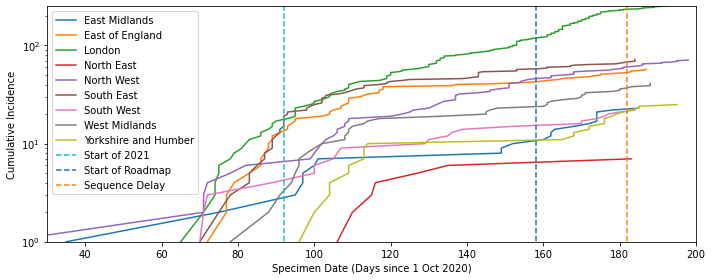

In [70]:
plt.figure(figsize=(10,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
for i, d in keydates.iterrows():
    plt.plot(todays(d)*np.ones(2),np.array([0,250]),ls='--',label=d.date_name)
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.xlim([30,200])
plt.ylim([1,250])
plt.yscale('log')
plt.tight_layout()
#plt.savefig('./voc_region_log.pdf')

In [75]:
# From the above, only London seems to exhibit exponential growth so look at that
li = np.argwhere(dfr.index == 'London')[0]
x = dfr[li].values[0]
x

array([191, 189, 192, 189, 191, 190, 189, 183, 189, 167, 189, 186, 187,
       187, 186, 186, 186, 185, 185, 181, 181, 182, 177, 180, 180, 177,
       179, 178, 180, 177, 178, 176, 176, 174, 175, 174, 175, 175, 174,
       174, 172, 173, 174, 173, 173, 173, 172, 172, 172, 171, 172, 172,
       170, 172, 170, 171, 170, 171, 169, 172, 167, 171, 168, 170, 166,
       170, 170, 167, 170, 169, 169, 169, 168, 168, 167, 167, 167, 161,
       165, 166, 165, 167, 164, 165, 165, 165, 165, 165, 165, 165, 165,
       164, 165, 164, 165, 163, 165, 164, 164, 163, 163, 164, 163, 162,
       163, 162, 162, 162, 162, 161, 161, 161, 161, 159, 160, 158, 157,
       159, 157, 156, 155, 154, 151, 154, 153, 153, 153, 154, 153, 153,
       153, 153, 153, 152, 153, 152, 152, 151, 151, 150, 148, 147, 149,
       147, 145, 146, 146, 143, 144, 141, 140, 141, 139, 133, 134, 134,
       134, 133, 133, 132, 132, 132, 132, 132, 131, 130, 130, 119, 130,
       129, 127, 125, 123, 122, 123, 120, 120, 120, 120, 119, 11